In [49]:
using Plots;
using Formatting;
gadfly();

In [43]:
include("../fdtd/update.jl");
include("../fdtd/sources.jl");
include("../fdtd/boundaries.jl");
using update;
using sources;

In [82]:
# Global parameters
size = 5000;
endTime = 20000;
num_snaps = 1000;
snap_step = div(endTime, num_snaps);

snaptime = 18000;
snap = zeros(size);

# Pulse
delay = 5000.;
width = 5000.;
inc_pos = 1000.;

# Monitors
refl = 0.0;
reflection_counter = zeros(num_snaps);
refl_counter_pos = 50;

trans = 0.0;
transmission_counter = zeros(num_snaps);
trans_counter_pos = 3000;

# Medium

eps1 = 42;
eps0 = 1;

#Grid

# Magnetic
hy = zeros(size);
mu = ones(size);

chyh = ones(size);
chye = ones(size);


# Electric
ez = zeros(size);
eps = ones(size);

cezh = ones(size);
ceze = ones(size);


for i in 1:div(size, 2) - 1
    eps[i] = eps0;
end
for i in div(size, 2):size
    eps[i] = eps1;
end

#
# setup CPML
#

# constants
dx = 1.0;
R0 = 1e-5;
m = 2.85;
#m = 4;
pml_width = 20.0;

# coeffs
sigma_max = -(m+1)*log(R0)/2/globals.imp0/(pml_width*dx)
sigma_x = zeros(size);
sigma_m_x = zeros(size);

for i in 1:round(Int, pml_width)
    sigma_x[i+1] = sigma_max * real(Complex(((pml_width-(i-1)-0.5)/pml_width))^m)
    sigma_m_x[i] = sigma_max * real(Complex(((pml_width-(i-1))/pml_width))^m)
    
    sigma_x[size-(i-1)] = sigma_max * real(Complex(((pml_width-i-0.5)/pml_width))^m)  
    sigma_m_x[size-(i-1)] = sigma_max * real(Complex(((pml_width-i)/pml_width))^m)
end

aex = exp(-sigma_x .* globals.imp0)-1
bex = exp(-sigma_x .* globals.imp0)

ahx = exp(-sigma_m_x .* globals.imp0)-1
bhx = exp(-sigma_m_x .* globals.imp0)

# arrays
p_hy = zeros(size);
p_ez = zeros(size);

# output params
ez_snapshot = Array{Any}(num_snaps);
hy_snapshot = Array{Any}(num_snaps);


In [83]:
# Time steps

for time in 1:endTime
    # Incident   
    ez_inc = exp(-(time + 0.5 - (-0.5) - delay) * (time + 0.5 - (-0.5) - delay) / width);
    hy_inc = exp(-(time - delay) * (time - delay) / width);


    #
    # Magnetic
    #

    # CPML
    for i in 1:size-1
        p_hy[i] = bhx[i]*p_hy[i] + ahx[i]*(ez[i+1] - ez[i])
    end
           
    # Interior update
    for i = 1:size-1
        hy[i] = chyh[i] * hy[i] + chye[i] * (ez[i+1] - ez[i]) / globals.imp0 / mu[i]
    end
       
    # CPML
    for i in 1:size-1
        hy[i] += p_hy[i]/globals.imp0/mu[i]
    end

    # TFSF
    hy[inc_pos-1] -= hy_inc / globals.imp0 / mu[inc_pos-1]
    
    #
    # Electric
    #
    
    # CPML
    for i in 2:size
        p_ez[i] = bex[i]*p_ez[i] + aex[i]*(hy[i] - hy[i-1])
    end

    # Interior update
    for i = 2:size
        ez[i] = ceze[i] * ez[i] + cezh[i] * (hy[i] - hy[i-1]) * globals.imp0 / eps[i]
    end  
 
    # CPML
    for i in 2:size
        ez[i] += p_ez[i]*globals.imp0/eps[i]
    end
    # TFSF
    ez[inc_pos] += ez_inc / eps[inc_pos]

    
    refl += (abs(ez[refl_counter_pos]*hy[refl_counter_pos-1]));
    trans +=(abs(ez[trans_counter_pos]*hy[trans_counter_pos-1]));
    
    # Snapshots for animation
    #if mod(time, snap_step) == 0
    #    t = div(time,snap_step)
    #    ez_snapshot[t] = (time, copy(ez))
    #    hy_snapshot[t] = (time, copy(hy).*globals.imp0)        

    #    # Counters
    #        reflection_counter[t] = refl;
    #        transmission_counter[t] = trans;
    #end 
    
    if time == snaptime
        snap = copy(ez)
    end
    
end

In [ ]:
anim = Animation()

for i = 1:num_snaps
    p = plot(1:size, ez_snapshot[i][2], lab="Ez")
    plot!(1:size, hy_snapshot[i][2], lab="Hy*imp0")
    
    time = ez_snapshot[i][1]
    plot!(ann=[(size*0.8, 1.5, "time =$time")])
    plot!(ann=[(0, 1.1, "CMPL")])
    
    plot!(ann=[(size/2-size*0.1, 1.2, "Eps = $eps0")])
    plot!(ann=[(size/2, 1.1, "Eps = $eps1")])    
    plot!([size/2, size/2], [-2, 2])
    
    plot!(ann=[(size*0.9, 1.1, "CPML")])
    
    R = fmt( "1.2e", reflection_counter[i])
    plot!(ann=[(refl_counter_pos, -1.1, "R = $R")])
    plot!([refl_counter_pos, refl_counter_pos], [-1, 1])
    
    T = fmt( "1.2e", transmission_counter[i])
    plot!(ann=[(trans_counter_pos, -1.1, "T = $T")])    
    plot!([trans_counter_pos, trans_counter_pos], [-1, 1])
    
    plot!(xlims=(1, size), ylims=(-2, 2))
    frame(anim, p)
end
gif(anim, "./Task2/Eps9_Reflection.gif", fps=15)

In [84]:
R = refl / (trans + refl)
F_R = abs((sqrt(eps0)-sqrt(eps1))/(sqrt(eps0)+sqrt(eps1)))^2
err = abs(( F_R - R) / F_R) * 100.
print("FDTD R = $R\n")
print("Frensel R = $F_R\n")
print("Error = $err%\n")

FDTD R = 0.5370269233939567
Frensel R = 0.536771326516269
Error = 0.04761746111637317%


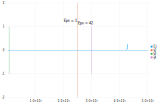

In [90]:
p = plot(1:size, snap, lab="Ez")
plot!(ann=[(size/2-size*0.1, 1.2, "Eps = $eps0")])
plot!(ann=[(size/2, 1.1, "Eps = $eps1")])    
plot!([size/2, size/2], [-2, 2])
    
plot!([refl_counter_pos, refl_counter_pos], [-1, 1])
    
plot!([trans_counter_pos, trans_counter_pos], [-1, 1])

plot!(xlims=(1, size), ylims=(-2, 2))